
<h1> <center> Analysis Impact of Regional Integration On Wind Energy</h1> 


###  <center> Yixuan Zou, yz3909 </center>
#### <center> December, 2021 </center>

#### <p> This project aims to analysis the effect of combining the diversity of wind time series across different wind resource regions and to answer the question whether more stable power can be produced when we connect regions. Analysis will be done using one year hourly capacity factor data of eight sites (shown in the Fig1), which indicates the wind potential. New York State hourly solar potential data and hourly electricity load data in 2011 will be used to analyse the possibility of fulfilling electricity load with renewable energy (wind and solar).</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime as dt
import pooch

doi = "doi:10.5281/zenodo.5739406"
fname = "wind_po_hrly.csv"
file_path = pooch.retrieve(
    url = f"{doi}/{fname}",
    known_hash= "md5:cf059b73d6831282c5580776ac07309a",
)
file_path
data=pd.read_csv(file_path)

print(data.head())

       date.time  ny_1_onshore  ny_2_onshore  newe_onshore  mw_onshore  \
0  1/1/2011 0:00      0.725240      0.450004      0.693996    0.646463   
1  1/1/2011 1:00      0.702001      0.446462      0.677913    0.688890   
2  1/1/2011 2:00      0.670164      0.432219      0.645567    0.717634   
3  1/1/2011 3:00      0.627149      0.436257      0.608017    0.745687   
4  1/1/2011 4:00      0.580882      0.456108      0.584728    0.767698   

   newe_offshore  ny_offshore  rfce_offshore  srvc_offshore  
0       0.759451     0.528019       0.353946       0.189323  
1       0.767231     0.530822       0.357297       0.212965  
2       0.764237     0.538845       0.374450       0.232722  
3       0.760258     0.541974       0.387670       0.246672  
4       0.759814     0.552363       0.393835       0.261140  


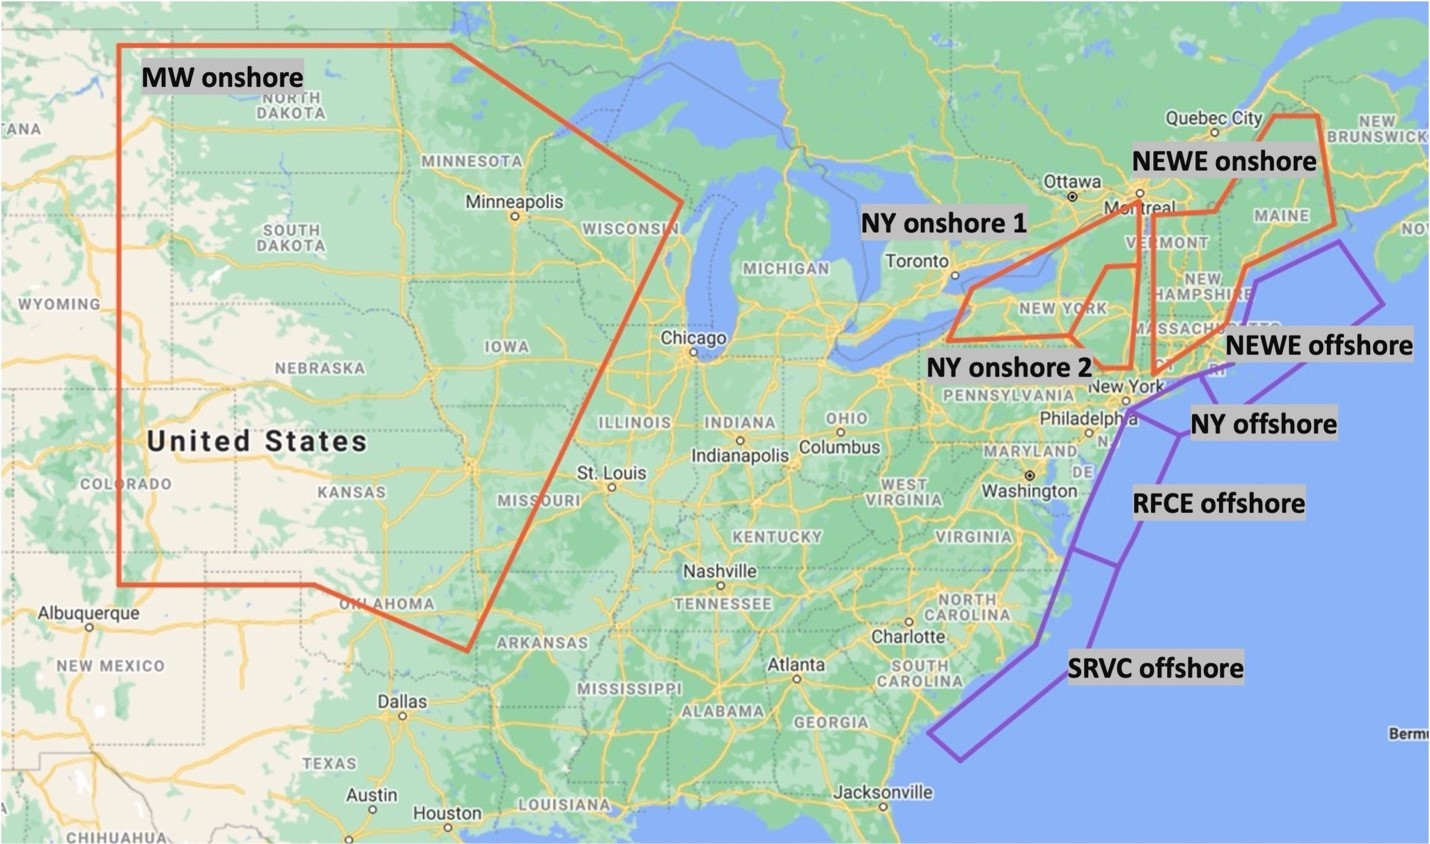

<ol>
<li> NY1 (NY_1 onshore; column B in csv file)</li>
<li> NY2 (NY_2 onshore; column C in csv file)</li>
<li> New England (NEWE onshore; column D in csv file)</li>
<li> Midwest (MW onshore; column E in csv file)</li>
<li> OSW1 (NEWE offshore; column F in csv file)</li>
<li> OSW2 (NY offshore; column G in csv file)</li>
<li> OSW3 (RFCE offshore; column H in csv file)</li>
<li> OSW4 (SRVC offshore; column I in csv file)</li>
</ol>


#### <p>Hourly capacity factor data in 2011 for each site is provided in "wind_po_hrly.csv", which is already the aggregated data from multiple locations into one location. Values are between 0 and 1 that indicating the wind power generating potential for the turbine that installed in local area. For onshore area,the rated power for each turbine is 2 MW while the offshore are 6 MW, this is coordinated with the wind resource availability since onshore generally has less wind resource potential than offshore area.</p>
<h2>1. Combination of wind turbines to achive average 10 GW output</h2>

#### <p>Firstly, averagly 10 GW output is choosen to the standarized analysis parameter for combining the wind turbines together. It is not required to have a 10 GW output every single hour, but we consider the annual output of the combination of wind turbines in each site can meet the requirement of 10GW * 8760 hours = 87600 GWh in a year.</p>


In [2]:
locations =  data.columns[1:]
turbine_power = [2,2,2,2,6,6,6,6]

In [3]:
number_of_turbines = []
for i in range(len(locations)):
    number_of_turbines.append(10000/(data[locations[i]].mean()*turbine_power[i]))
    print("Number of turbine for 10 GW for site",i+1,"is:","%.2f" % number_of_turbines[i])

Number of turbine for 10 GW for site 1 is: 16883.76
Number of turbine for 10 GW for site 2 is: 16703.97
Number of turbine for 10 GW for site 3 is: 10984.08
Number of turbine for 10 GW for site 4 is: 10931.94
Number of turbine for 10 GW for site 5 is: 3034.32
Number of turbine for 10 GW for site 6 is: 3357.26
Number of turbine for 10 GW for site 7 is: 3554.75
Number of turbine for 10 GW for site 8 is: 3460.91


<h2>2. Hour fraction in each power output range</h2>

#### <p> Combining wind turbines in individual spots can meet the assumption of generating averagly 10GW power output for each site. In the next step, calculation has been done for the fraction of hour in each power output range for site individually and the conbination sites.In order to get the fraction, data was processed as follows:</p>
<ol> 
    <li><strong>Calculate the total generation for the individual site in each hour.</strong></li>
<em>Total power generation in each hour = [individual turbine rated power] * [number of combined turbines] * [Capacity Factor]</em>
    <li><strong>Calculate the total generation for the combined wind turbines in each hour.</strong></li>
<em>Total power generation in each hour = (contribution percentage)*([individual turbine rated power] * [number of combined turbines] * [Capacity Factor])</em>
    <li><strong>Iterate through each column, count the number of hour that falls into each power range,then calculation time fraction of each power range.</strong></li>
<em>Proportion of power range = [number of hour in each power range] / [total hour] </em>
<ol>        



<h3> 2.1 Time fraction for the individual site in different power generation range</h3>

In [4]:
locations =  data.columns[1:]
hourly_energy_generation = []
for i in range(len(locations)):
    hourly_energy_generation.append(number_of_turbines[i]*data[locations[i]]*turbine_power[i])
    

In [5]:
power_generation = xr.DataArray(data = hourly_energy_generation)

In [6]:
fraction_less_two = []
# Calculate the hourly propotion for power generation less than 2GW in individual site
for i in range(len(hourly_energy_generation)):
    less_than_two = data[locations[i]]*number_of_turbines[i]*turbine_power[i] <= 2000
    count = np.count_nonzero(less_than_two)
    fraction_less_two.append("%.2f"%((count/len(data[locations[i]]))*100))


fraction_two_to_six = [] 
# Calculate the hourly propotion for power generation 2GW - 6GW in individual site
for i in range(len(hourly_energy_generation)):
    two_to_six = (data[locations[i]]*number_of_turbines[i]*turbine_power[i] > 2000) & (data[locations[i]]*number_of_turbines[i]*turbine_power[i] <=6000)
    count_two_to_six = np.count_nonzero(two_to_six)
    fraction_two_to_six.append("%.2f"%(count_two_to_six/len(data[locations[i]])*100))

fraction_six_to_ten = []
# Calculate the hourly propotion for power generation 6GW - 10GW in individual site
for i in range(len(hourly_energy_generation)):
    six_to_ten = (data[locations[i]]*number_of_turbines[i]*turbine_power[i] > 6000) & (data[locations[i]]*number_of_turbines[i]*turbine_power[i] <=10000)
    count_six_to_ten = np.count_nonzero(six_to_ten)
    fraction_six_to_ten.append("%.2f"%(count_six_to_ten/len(data[locations[i]])*100))

    
fraction_above10 = []
# Calculate the hourly propotion for power generation above 10GW in individual site
for i in range(len(hourly_energy_generation)):
    above_ten = (data[locations[i]]*number_of_turbines[i]*turbine_power[i] > 10000)
    above_ten = np.count_nonzero(above_ten)
    fraction_above10.append("%.2f"%( above_ten/len(data[locations[i]])*100))


<h3> 2.2 Time fraction for combined sites in different power generation range.</h3>

In [7]:
combine = pd.DataFrame()
combine["site1234"]= 0.25 * (data[locations[0]]* number_of_turbines[0]+data[locations[1]]* number_of_turbines[1]+data[locations[2]]* number_of_turbines[2]+data[locations[3]]* number_of_turbines[3])*2 
combine["site1256"]= 0.25 * ((data[locations[0]]* number_of_turbines[0]+data[locations[1]]* number_of_turbines[1])*2+(data[locations[4]]* number_of_turbines[4]+data[locations[5]]* number_of_turbines[5])*6) 
combine["site5678"]= 0.25 * (data[locations[4]]* number_of_turbines[4]+data[locations[5]]* number_of_turbines[5]+data[locations[6]]* number_of_turbines[6]+data[locations[7]]* number_of_turbines[7])*6
combine["all_sites"]= 0.125 *( ((data[locations[0]]* number_of_turbines[0]+data[locations[1]]* number_of_turbines[1]+data[locations[2]]* number_of_turbines[2]+data[locations[3]]* number_of_turbines[3])*2)
                            + ((data[locations[4]]* number_of_turbines[4]+data[locations[5]]* number_of_turbines[5]+data[locations[6]]* number_of_turbines[6]+data[locations[7]]* number_of_turbines[7])*6))
combine.head()

,site1234,site1256,site5678,all_sites
0,17225.819301,15996.496708,8985.811743,13105.815522
1,17143.626468,15820.252913,9175.937295,13159.781881
2,16735.371788,15459.305077,9396.737768,13066.054778
3,16353.090355,15127.556492,9537.293610,12945.191982
4,16120.703439,14953.064793,9695.577042,12908.140240


In [8]:
loc=  combine.columns[:]
c_less_two = [] 
#calculate the proportion of hour that wind turbines in the combined sites generate power less than 2GW
for i in range(len(loc)):
    less_two = combine[loc[i]]<=2000
    count_less_two = np.count_nonzero(less_two)
    c_less_two.append("%.2f"%(count_less_two/len(combine[loc[i]])*100))

c_26 = []
#calculate the proportion of hour that wind turbines in the combined sites generate power between 2GW to 6GW
for i in range(len(loc)):
    c2_6 = (combine[loc[i]]>2000)&(combine[loc[i]]<=6000)
    count_c2_6 = np.count_nonzero(c2_6)
    c_26.append("%.2f"%(count_c2_6/len(combine[loc[i]])*100))
    
c_610 = []
#calculate the proportion of hour that wind turbines in the combined sites generate power between 6GW to 10GW
for i in range(len(loc)):
    c6_10 = (combine[loc[i]]>6000)&(combine[loc[i]]<=10000)
    count_c6_10 = np.count_nonzero(c6_10)
    c_610.append("%.2f"%(count_c6_10/len(combine[loc[i]])*100))

c_10 =[]
#calculate the proportion of hour that wind turbines in the combined sites generate power above 10GW
for i in range(len(loc)):
    above10 = combine[loc[i]]>10000
    count_above10 = np.count_nonzero(above10)
    c_10.append("%.2f"%(count_above10/len(combine[loc[i]])*100))
 

In [9]:
fraction_combine = pd.DataFrame({"<2GW":c_less_two,"2GW-6GW":c_26,"6GW-10GW":c_610,">10GW":c_10})
fraction_combine

,<2GW,2GW-6GW,6GW-10GW,>10GW
0,2.56,26.85,26.37,44.22
1,6.84,26.06,22.68,44.42
2,3.65,24.69,25.39,46.27
3,0.99,24.22,29.03,45.75


<h3> 2.3 Summarize individual site and combined sites in a table.</h3>

In [10]:
fraction_combine1=fraction_combine.transpose()
fraction_table = pd.DataFrame({"<2GW":fraction_less_two,"2GW-6GW":fraction_two_to_six,"6GW-10GW":fraction_six_to_ten,">10GW":fraction_above10})

fraction_table=fraction_table.rename(index={0:"site1",1:"site2",2:"site3",3:"site4",4:"site5",5:"site6",6:"site7",7:"site8"}).T
fraction_table["site1234"]= fraction_combine1.iloc[:,0]
fraction_table["site1256"]= fraction_combine1.iloc[:,1]
fraction_table["site5678"]= fraction_combine1.iloc[:,2]
fraction_table["all_sites"]= fraction_combine1.iloc[:,3]
fraction_table

,site1,site2,site3,site4,site5,site6,site7,site8,site1234,site1256,site5678,all_sites
<2GW,15.51,19.34,8.89,2.76,11.15,16.11,16.83,7.67,2.56,6.84,3.65,0.99
2GW-6GW,28.60,24.26,22.80,19.58,20.82,18.49,20.94,22.52,26.85,26.06,24.69,24.22
6GW-10GW,17.25,14.82,19.76,29.09,15.64,17.25,15.76,21.37,26.37,22.68,25.39,29.03
>10GW,38.64,41.59,48.55,48.57,52.39,48.15,46.47,48.44,44.22,44.42,46.27,45.75


<h3>Annually Power Generation in each site and combination 

In [11]:
power_generation = pd.DataFrame(data = hourly_energy_generation).T
power_generation["site1234"]= combine.iloc[:,0]
power_generation["site1256"]= combine.iloc[:,1]
power_generation["site5678"]= combine.iloc[:,2]
power_generation["all_sites"]= combine.iloc[:,3]
power_generation["time"]=pd.to_datetime(data['date.time'])
df=power_generation.set_index('time')
df.head()

,ny_1_onshore,ny_2_onshore,newe_onshore,mw_onshore,newe_offshore,ny_offshore,rfce_offshore,srvc_offshore,site1234,site1256,site5678,all_sites
time,,,,,,,,,,,,
2011-01-01 00:00:00,24489.570809,15033.690574,15245.824723,14134.191098,13826.528713,10636.196738,7549.150947,3931.370577,17225.819301,15996.496708,8985.811743,13105.815522
2011-01-01 01:00:00,23704.840489,14915.357204,14892.512059,15061.796117,13968.160031,10692.653927,7620.618311,4422.316910,17143.626468,15820.252913,9175.937295,13159.781881
2011-01-01 02:00:00,22629.765813,14439.543819,14181.912143,15690.265379,13913.647328,10854.263346,7986.464850,4832.575548,16735.371788,15459.305077,9396.737768,13066.054778
2011-01-01 03:00:00,21177.276158,14574.451165,13357.018891,16303.615205,13841.208946,10917.289701,8268.425492,5122.250302,16353.090355,15127.556492,9537.293610,12945.191982
2011-01-01 04:00:00,19614.929862,15237.628565,12845.393369,16784.861958,13833.131189,11126.569557,8399.914225,5422.693199,16120.703439,14953.064793,9695.577042,12908.140240


In [12]:
time = df.index
site = df.columns[0:]

da_cf = xr.Dataset(data_vars={
    'capacity_factor':(['time','site'],df)
},
                   coords={
                       'time':time,
                       'site':site}
                  )
da_cf

<xarray.Dataset>
Dimensions:          (time: 8760, site: 12)
Coordinates:
  * time             (time) datetime64[ns] 2011-01-01 ... 2011-12-31T23:00:00
  * site             (site) object 'ny_1_onshore' 'ny_2_onshore' ... 'all_sites'
Data variables:
    capacity_factor  (time, site) float64 2.449e+04 1.503e+04 ... 1.217e+04

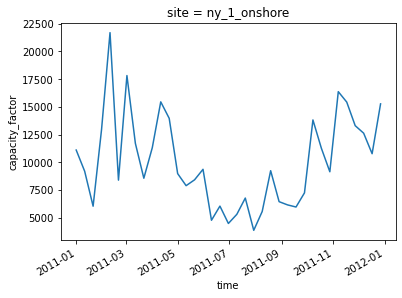

In [13]:
da_cf.capacity_factor.sel(site='ny_1_onshore').resample(time='10D').mean().plot()

ds = df.to_xarray()
ds

In [14]:
djf = da_cf.isel(time=da_cf.time.dt.month.isin([12,1,2]))
mam = da_cf.isel(time=da_cf.time.dt.month.isin([3,4,5]))
jja = da_cf.isel(time=da_cf.time.dt.month.isin([6,7,8]))
son = da_cf.isel(time=da_cf.time.dt.month.isin([9,10,11]))

In [15]:
djf_m = djf.mean('time')/(djf.mean()+mam.mean()+jja.mean()+son.mean())

In [16]:
mam_m = mam.mean('time')/(djf.mean()+mam.mean()+jja.mean()+son.mean())

In [17]:
jja_m = jja.mean('time')/(djf.mean()+mam.mean()+jja.mean()+son.mean())

In [18]:
son_m = son.mean('time')/(djf.mean()+mam.mean()+jja.mean()+son.mean())

In [19]:
seasonal_fraction = djf_m.to_dataframe().rename(columns={"capacity_factor":"djf"})

In [20]:
seasonal_fraction['mam']= mam_m.to_dataframe().rename(columns={"capacity_factor":"mam"})
seasonal_fraction['jja']= jja_m.to_dataframe().rename(columns={"capacity_factor":"jja"})
seasonal_fraction['son']= son_m.to_dataframe().rename(columns={"capacity_factor":"son"})
seasonal_fraction_T = seasonal_fraction.T
seasonal_fraction_T

site,ny_1_onshore,ny_2_onshore,newe_onshore,mw_onshore,newe_offshore,ny_offshore,rfce_offshore,srvc_offshore,site1234,site1256,site5678,all_sites
djf,0.294683,0.293541,0.281153,0.266952,0.275152,0.274259,0.286421,0.286086,0.284082,0.284409,0.280479,0.282281
mam,0.285654,0.314927,0.286175,0.270836,0.286271,0.291667,0.305961,0.276699,0.289398,0.294630,0.290149,0.289774
jja,0.154928,0.157559,0.181450,0.204498,0.189009,0.184694,0.165689,0.193583,0.174608,0.171547,0.183244,0.178926
son,0.265177,0.234051,0.251217,0.257468,0.249414,0.249203,0.241938,0.243653,0.251978,0.249461,0.246052,0.249015


In [21]:
data['time'] = pd.to_datetime(data['date.time'])
df_cf = data.set_index('time')
del df_cf['date.time']
ds_cf = df_cf.to_xarray()

ds_cf.mean()
ds_cf.mean()
ds_cf['site1234']= 0.25*(ds_cf.ny_1_onshore+ds_cf.ny_2_onshore+ds_cf.newe_onshore+ds_cf.mw_onshore)
ds_cf['site1256']= 0.25*(ds_cf.ny_1_onshore+ds_cf.ny_2_onshore+ds_cf.newe_offshore+ds_cf.ny_offshore)
ds_cf['site5678']= 0.25*(ds_cf.newe_offshore+ds_cf.ny_offshore+ds_cf.rfce_offshore+ds_cf.srvc_offshore)
ds_cf['all_sites']= 0.125*(ds_cf.ny_1_onshore+ds_cf.ny_2_onshore+ds_cf.newe_onshore+ds_cf.mw_onshore+ds_cf.newe_offshore+ds_cf.ny_offshore+ds_cf.rfce_offshore+ds_cf.srvc_offshore)
ds_cf

<xarray.Dataset>
Dimensions:        (time: 8760)
Coordinates:
  * time           (time) datetime64[ns] 2011-01-01 ... 2011-12-31T23:00:00
Data variables:
    ny_1_onshore   (time) float64 0.7252 0.702 0.6702 ... 0.2336 0.2565 0.2531
    ny_2_onshore   (time) float64 0.45 0.4465 0.4322 ... 0.2478 0.3082 0.3699
    newe_onshore   (time) float64 0.694 0.6779 0.6456 ... 0.1795 0.2908 0.3868
    mw_onshore     (time) float64 0.6465 0.6889 0.7176 ... 0.7623 0.8226 0.8802
    newe_offshore  (time) float64 0.7595 0.7672 0.7642 ... 0.3237 0.3145 0.4689
    ny_offshore    (time) float64 0.528 0.5308 0.5388 ... 0.3624 0.5067 0.6776
    rfce_offshore  (time) float64 0.3539 0.3573 0.3744 ... 0.5981 0.7545 0.7837
    srvc_offshore  (time) float64 0.1893 0.213 0.2327 ... 0.5161 0.5112 0.4739
    site1234       (time) float64 0.6289 0.6288 0.6164 ... 0.3558 0.4195 0.4725
    site1256       (time) float64 0.6157 0.6116 0.6014 ... 0.2919 0.3465 0.4424
    site5678       (time) float64 0.4577 0.4671 0.4776 ... 0.4501 0.5217 0.601
    all_sites      (time) float64 0.5433 0.5479 0.547 ... 0.4029 0.4706 0.5368

In [22]:
ds_cf.mean()

<xarray.Dataset>
Dimensions:        ()
Data variables:
    ny_1_onshore   float64 0.2961
    ny_2_onshore   float64 0.2993
    newe_onshore   float64 0.4552
    mw_onshore     float64 0.4574
    newe_offshore  float64 0.5493
    ny_offshore    float64 0.4964
    rfce_offshore  float64 0.4689
    srvc_offshore  float64 0.4816
    site1234       float64 0.377
    site1256       float64 0.4103
    site5678       float64 0.499
    all_sites      float64 0.438

In [23]:
pm11_am5 = da_cf.isel(time=da_cf.time.dt.hour.isin([23,0,1,2,3,4]))
am5_am11 = da_cf.isel(time=da_cf.time.dt.hour.isin([5,6,7,8,9,10]))
am11_pm5 = da_cf.isel(time=da_cf.time.dt.hour.isin([11,12,13,14,15,16]))
pm5_pm11 = da_cf.isel(time=da_cf.time.dt.hour.isin([17,18,19,20,21,22]))

In [24]:
pm11_am5_m=pm11_am5.mean('time')/(pm11_am5.mean()+am5_am11.mean()+am11_pm5.mean()+pm5_pm11.mean())
am5_am11_m=am5_am11.mean('time')/(pm11_am5.mean()+am5_am11.mean()+am11_pm5.mean()+pm5_pm11.mean())
am11_pm5_m=am11_pm5.mean('time')/(pm11_am5.mean()+am5_am11.mean()+am11_pm5.mean()+pm5_pm11.mean())
pm5_pm11_m=pm5_pm11.mean('time')/(pm11_am5.mean()+am5_am11.mean()+am11_pm5.mean()+pm5_pm11.mean())

time_fraction = pm11_am5_m.to_dataframe().rename(columns={"capacity_factor":"pm11_am5"})
time_fraction['am5_am11'] = am5_am11_m.to_dataframe().rename(columns={"capacity_factor":"am5_am11"})
time_fraction['am11_pm5'] = am11_pm5_m.to_dataframe().rename(columns={"capacity_factor":"am11_pm5"})
time_fraction['pm5_pm11'] = pm5_pm11_m.to_dataframe().rename(columns={"capacity_factor":"pm5_pm11"})
time_fraction=time_fraction.T
time_fraction

site,ny_1_onshore,ny_2_onshore,newe_onshore,mw_onshore,newe_offshore,ny_offshore,rfce_offshore,srvc_offshore,site1234,site1256,site5678,all_sites
pm11_am5,0.285889,0.290093,0.277586,0.279239,0.263481,0.278982,0.271405,0.267140,0.283202,0.279611,0.270252,0.276727
am5_am11,0.274829,0.263770,0.254088,0.299594,0.247193,0.252970,0.256586,0.259125,0.273070,0.259690,0.253968,0.263519
am11_pm5,0.217150,0.212504,0.221254,0.229307,0.236219,0.221383,0.226446,0.230902,0.220054,0.221814,0.228737,0.224396
pm5_pm11,0.222132,0.233633,0.247071,0.191860,0.253108,0.246665,0.245564,0.242833,0.223674,0.238884,0.247042,0.235358


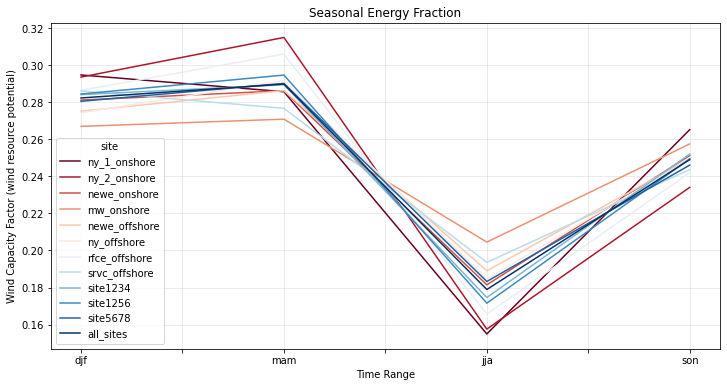

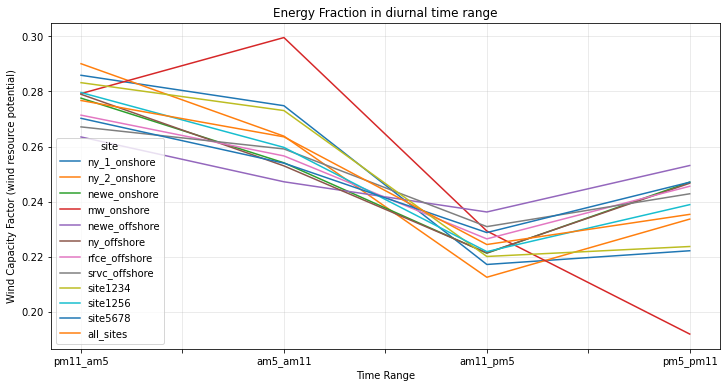

In [25]:
plt.rcParams['figure.figsize'] = (12, 6)
seasonal_fraction_T.plot(cmap='RdBu')
plt.grid(alpha=0.3)
plt.ylabel('Wind Capacity Factor (wind resource potential)');
plt.xlabel('Time Range');
plt.title('Seasonal Energy Fraction');
time_fraction.plot()
plt.grid(alpha=0.3)
plt.ylabel('Wind Capacity Factor (wind resource potential)');
plt.xlabel('Time Range');
plt.title('Energy Fraction in diurnal time range');

<h2>Part2
    
 #### <p> In this part, the low energy production range (total generation less than 2GW) is studied in both seasonal and diurnal dimensions.</p>

In [26]:
djf_low = (djf<2000).sum('time')
mam_low = (mam<2000).sum('time')
jja_low = (jja<2000).sum('time')
son_low = (son<2000).sum('time')

In [27]:
seasonal_low = djf_low.to_dataframe().rename(columns={"capacity_factor":"djf"})
seasonal_low['mam']=mam_low.to_dataframe().rename(columns={"capacity_factor":"mam"})
seasonal_low['jja']=jja_low.to_dataframe().rename(columns={"capacity_factor":"jja"})
seasonal_low['son']=son_low.to_dataframe().rename(columns={"capacity_factor":"son"})
seasonal_low=seasonal_low.T
seasonal_low

site,ny_1_onshore,ny_2_onshore,newe_onshore,mw_onshore,newe_offshore,ny_offshore,rfce_offshore,srvc_offshore,site1234,site1256,site5678,all_sites
djf,282,314,150,9,219,320,317,133,13,92,62,4
mam,302,311,152,13,190,248,169,74,12,111,38,5
jja,510,633,291,110,322,470,486,245,144,278,112,55
son,265,436,186,110,246,373,502,220,55,118,108,23


In [28]:
pm11_am5_low = (pm11_am5<2000).sum('time')
am5_am11_low = (am5_am11<2000).sum('time')
am11_pm5_low = (am11_pm5<2000).sum('time')
pm5_pm11_low = (pm5_pm11<2000).sum('time')

In [29]:
hourly_low = pm11_am5_low.to_dataframe().rename(columns={"capacity_factor":"pm11_am5"})
hourly_low['am5_am11'] = am5_am11_low.to_dataframe().rename(columns={"capacity_factor":"am5_am11"})
hourly_low['am11_pm5'] = am11_pm5_low.to_dataframe().rename(columns={"capacity_factor":"am11_pm5"})
hourly_low['pm5_pm11'] = pm5_pm11_low.to_dataframe().rename(columns={"capacity_factor":"pm5_pm11"})
hourly_low=hourly_low.T
hourly_low

site,ny_1_onshore,ny_2_onshore,newe_onshore,mw_onshore,newe_offshore,ny_offshore,rfce_offshore,srvc_offshore,site1234,site1256,site5678,all_sites
pm11_am5,208,267,93,13,211,241,302,134,3,66,54,0
am5_am11,225,365,159,0,242,358,348,169,5,113,82,0
am11_pm5,495,574,303,85,289,474,442,197,111,258,136,61
pm5_pm11,431,488,224,144,235,338,382,172,105,162,48,26


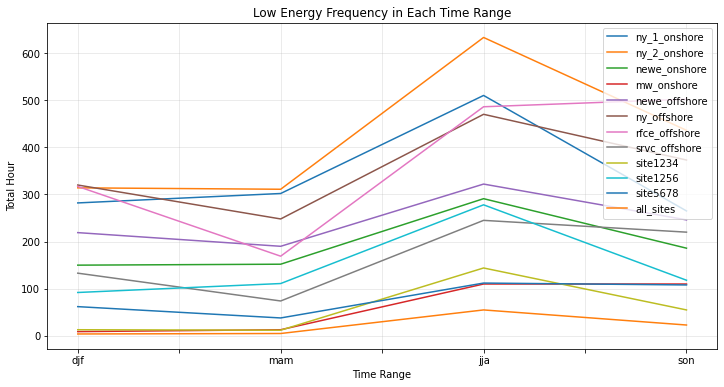

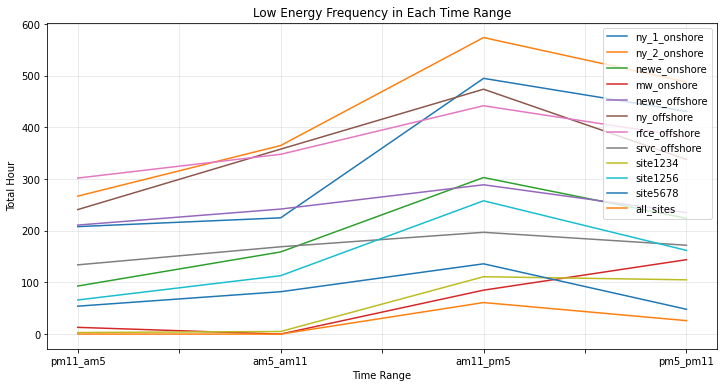

In [30]:
plt.rcParams['figure.figsize'] = (12, 6)
seasonal_low.plot()
plt.grid(alpha=0.3)
plt.ylabel('Total Hour');
plt.xlabel('Time Range');
plt.title('Low Energy Frequency in Each Time Range');
plt.legend(loc='upper right')

hourly_low.plot()
plt.grid(alpha=0.3)
plt.ylabel('Total Hour');
plt.xlabel('Time Range');
plt.title('Low Energy Frequency in Each Time Range');
plt.legend(loc='upper right')

June, July, August has the largest number of hours that the total power generation was below 2GW. While in a day, the time between 11 am to 5 pm has the largest number of hours that has lowest power generation. 

<h3>Continuous Hour

In [31]:
df.head()

,ny_1_onshore,ny_2_onshore,newe_onshore,mw_onshore,newe_offshore,ny_offshore,rfce_offshore,srvc_offshore,site1234,site1256,site5678,all_sites
time,,,,,,,,,,,,
2011-01-01 00:00:00,24489.570809,15033.690574,15245.824723,14134.191098,13826.528713,10636.196738,7549.150947,3931.370577,17225.819301,15996.496708,8985.811743,13105.815522
2011-01-01 01:00:00,23704.840489,14915.357204,14892.512059,15061.796117,13968.160031,10692.653927,7620.618311,4422.316910,17143.626468,15820.252913,9175.937295,13159.781881
2011-01-01 02:00:00,22629.765813,14439.543819,14181.912143,15690.265379,13913.647328,10854.263346,7986.464850,4832.575548,16735.371788,15459.305077,9396.737768,13066.054778
2011-01-01 03:00:00,21177.276158,14574.451165,13357.018891,16303.615205,13841.208946,10917.289701,8268.425492,5122.250302,16353.090355,15127.556492,9537.293610,12945.191982
2011-01-01 04:00:00,19614.929862,15237.628565,12845.393369,16784.861958,13833.131189,11126.569557,8399.914225,5422.693199,16120.703439,14953.064793,9695.577042,12908.140240


In [32]:
c_locations = df.columns

In [33]:
is_lowenergy = pd.DataFrame()
data_conti = pd.DataFrame()

for i in range(len(c_locations)):
    is_lowenergy[c_locations[i]] = df[c_locations[i]] < 2000
    data_conti[c_locations[i]] = is_lowenergy[c_locations[i]].groupby((is_lowenergy[c_locations[i]] != is_lowenergy[c_locations[i]].shift()).cumsum()).transform('size') * is_lowenergy[c_locations[i]]

In [34]:
conti_result = pd.DataFrame()
conti_range = [range(36,50),range(24,36),range(12,24)]

for i in range(len(c_locations)):
    R = []
    R.append(data_conti[c_locations[i]].max())
    for j in conti_range:
        sum_hour = 0
        for k in j:
            sum_hour += (data_conti[c_locations[i]] == k).sum()/k
        R.append(int(sum_hour))
    conti_result[c_locations[i]] = R

conti_result.index = ["Longest",">36","24~36","12~24"]
conti_result

,ny_1_onshore,ny_2_onshore,newe_onshore,mw_onshore,newe_offshore,ny_offshore,rfce_offshore,srvc_offshore,site1234,site1256,site5678,all_sites
Longest,43,55,23,15,59,68,55,59,14,35,45,9
>36,3,1,0,0,1,1,2,2,0,0,1,0
24~36,5,5,0,0,6,4,4,1,0,2,0,0
12~24,28,48,24,1,12,32,32,16,1,15,5,0


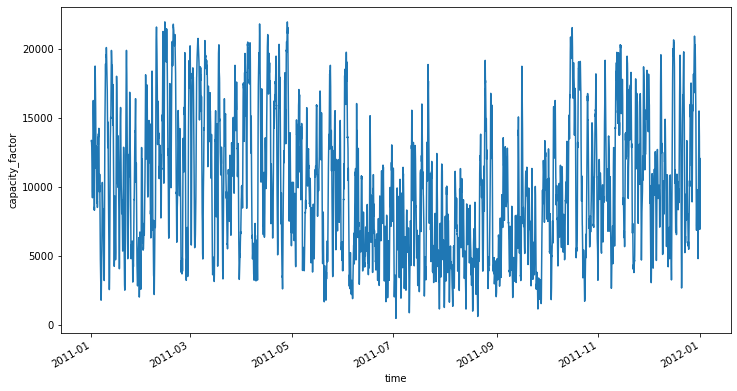

In [35]:
da_cf.capacity_factor.mean(dim='site').plot()

t=0 ## alter to dataframe

m=[]

for i in range(len(site1)):
    if site1[i]==True:
        t=t+1
    else:
        m.append(t)
        t=0
max(m)

### Renewable Energy Supply vs Electricity Demand in New York

In [36]:
doi = "doi:10.5281/zenodo.5739406"
fname = "wind_po_hrly.csv"
file_path = pooch.retrieve(
    url = f"{doi}/{fname}",
    known_hash= "md5:cf059b73d6831282c5580776ac07309a",
)
file_path
data=pd.read_csv(file_path)

data_energy = pd.DataFrame(data,columns = ["date.time"])


locations = data.columns.values[1:]
turbine_power = [2,2,2,2,6,6,6,6]


Num_turbine = []
for i in range(len(locations)):
    Num_turbine.append(10000 / (turbine_power[i] * data[locations[i]].mean()))

for i in range(len(locations)):
    data_energy[locations[i]] = data[locations[i]] * Num_turbine[i] * turbine_power[i]
    
    
data_energy["Site1234"] = 0.25 * (data_energy[locations[0]] + data_energy[locations[1]] 
                           + data_energy[locations[2]] + data_energy[locations[3]])

data_energy["Site1256"] = 0.25 * (data_energy[locations[0]] + data_energy[locations[1]] 
                           + data_energy[locations[4]] + data_energy[locations[5]])

data_energy["Site5678"] = 0.25 * (data_energy[locations[4]] + data_energy[locations[5]] 
                           + data_energy[locations[6]] + data_energy[locations[7]])

data_energy["All"] = 0.125 * (data_energy[locations[0]] + data_energy[locations[1]] 
                       + data_energy[locations[2]] + data_energy[locations[3]] 
                       + data_energy[locations[4]] + data_energy[locations[5]] 
                       + data_energy[locations[6]] + data_energy[locations[7]])
data_energy['time'] = pd.to_datetime(data_energy['date.time'])
df_wind = data_energy.set_index('time')
del df_wind['date.time']
df_wind = df_wind.to_xarray()


doi = "doi:10.5281/zenodo.5750726"
fname = "solar_po.csv"
file_path = pooch.retrieve(
    url = f"{doi}/{fname}",
    known_hash= "md5:b7acc6026f08ff062e03aa21625cc974",
)
file_path
data_solar=pd.read_csv(file_path)
data_solar

data_solar['time'] = pd.to_datetime(data_solar['datatime'])
df_solar = data_solar.set_index('time')
del df_solar['datatime']
df_solar = df_solar.to_xarray()


doi = "doi:10.5281/zenodo.5750734"
fname = "elec_load.csv"
file_path = pooch.retrieve(
    url = f"{doi}/{fname}",
    known_hash= "md5:c5bd92f180b57e8629b0ca3891d25812",
)
file_path
data_elec=pd.read_csv(file_path)

data_elec['time'] = pd.to_datetime(data_elec['datatime'])
df_elec = data_elec.set_index('time')
del df_elec['datatime']
df_elec = df_elec.to_xarray()

In [37]:
df_wind

<xarray.Dataset>
Dimensions:        (time: 8760)
Coordinates:
  * time           (time) datetime64[ns] 2011-01-01 ... 2011-12-31T23:00:00
Data variables:
    ny_1_onshore   (time) float64 2.449e+04 2.37e+04 ... 8.66e+03 8.547e+03
    ny_2_onshore   (time) float64 1.503e+04 1.492e+04 ... 1.03e+04 1.236e+04
    newe_onshore   (time) float64 1.525e+04 1.489e+04 ... 6.387e+03 8.497e+03
    mw_onshore     (time) float64 1.413e+04 1.506e+04 ... 1.798e+04 1.924e+04
    newe_offshore  (time) float64 1.383e+04 1.397e+04 ... 5.725e+03 8.537e+03
    ny_offshore    (time) float64 1.064e+04 1.069e+04 ... 1.021e+04 1.365e+04
    rfce_offshore  (time) float64 7.549e+03 7.621e+03 ... 1.609e+04 1.672e+04
    srvc_offshore  (time) float64 3.931e+03 4.422e+03 ... 1.062e+04 9.84e+03
    Site1234       (time) float64 1.723e+04 1.714e+04 ... 1.083e+04 1.216e+04
    Site1256       (time) float64 1.6e+04 1.582e+04 ... 8.722e+03 1.077e+04
    Site5678       (time) float64 8.986e+03 9.176e+03 ... 1.066e+04 1.219e+04
    All            (time) float64 1.311e+04 1.316e+04 ... 1.075e+04 1.217e+04

In [38]:
data_elec

,datatime,current_load,electrfied_load,time
0,1/1/11 0:00,19730.37500,38952.80538,2011-01-01 00:00:00
1,1/1/11 1:00,18931.00833,36982.89383,2011-01-01 01:00:00
2,1/1/11 2:00,18147.88333,35249.71582,2011-01-01 02:00:00
3,1/1/11 3:00,17314.59167,33518.93894,2011-01-01 03:00:00
4,1/1/11 4:00,16486.04167,31163.70434,2011-01-01 04:00:00
...,...,...,...,...
8755,12/31/11 19:00,17282.61667,30192.52799,2011-12-31 19:00:00
8756,12/31/11 20:00,17358.37500,30997.29075,2011-12-31 20:00:00
8757,12/31/11 21:00,18290.73333,33122.38496,2011-12-31 21:00:00
8758,12/31/11 22:00,19733.85833,36485.53286,2011-12-31 22:00:00


In [39]:
df_elec

<xarray.Dataset>
Dimensions:          (time: 8760)
Coordinates:
  * time             (time) datetime64[ns] 2011-01-01 ... 2011-12-31T23:00:00
Data variables:
    current_load     (time) float64 1.973e+04 1.893e+04 ... 1.973e+04 1.969e+04
    electrfied_load  (time) float64 3.895e+04 3.698e+04 ... 3.649e+04 3.799e+04

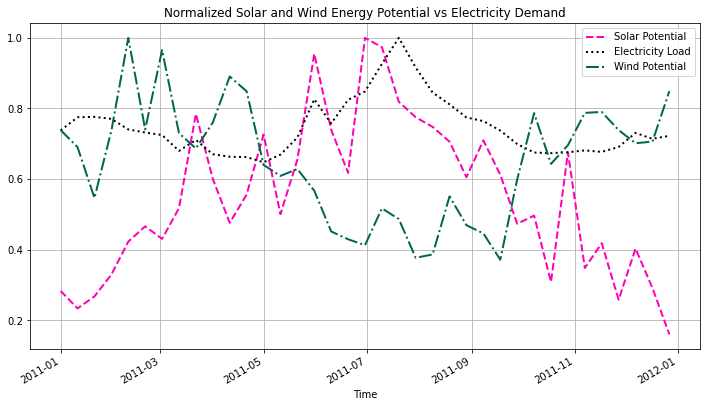

In [40]:
rs_solar = df_solar.resample(time='10D').mean('time')/df_solar.resample(time='10D').mean('time').max()
rs_elec = df_elec.resample(time='10D').mean('time')/df_elec.resample(time='10D').mean('time').max()
#rs_elec = df_elec.rolling(time=12, center = True).mean('time')/df_elec.rolling(time=12, center = True).mean('time').max()
rs_wind = df_wind.All.resample(time='10D').mean('time')/df_wind.resample(time='10D').mean('time').max()

rs_solar.electrfied_load.plot(linestyle='dashed',color=(1, 0, 0.7),linewidth=2,label='Solar Potential')
rs_elec.current_load.plot(color='k',linestyle='dotted',linewidth=2,label='Electricity Load')
rs_wind.All.plot(linestyle='-.', linewidth=2,color=(0, 0.4, 0.3),label='Wind Potential')
plt.grid()
plt.title('Normalized Solar and Wind Energy Potential vs Electricity Demand')
plt.xlabel("Time")
plt.ylabel("")
plt.legend()

In [41]:
len(df_wind.variables)

13

In [42]:
for i in range(len(df_wind.variables):
               ax[i].plot(

SyntaxError: invalid syntax (1041219957.py, line 1)

In [ ]:
rs_wind_12=df_wind.resample(time='10D').mean('time')
a = rs_wind_12.time.dt.month

In [ ]:
b = rs_wind_12.ny_1_onshore

In [ ]:
fig, ax = plt.subplots(figsize=(25,12),nrows=3,ncols=4)
ax[0].plot(a,b)

In [ ]:
fig, axes = plt.subplots(figsize=(25,12),nrows=3,ncols=4)

rs_wind_12=df_wind.resample(time='10D').mean('time')
rs_wind_12.ny_1_onshore.plot()
rs_demand_12 = df_elec.resample(time='10D').mean('time')
rs_demand_12.current_load.plot()